                                               CAPTCHA IMAGE DECODER
<img width = 300 height = 300 src="https://images.squarespace-cdn.com/content/v1/56eb3d2fe321407d6a06f3d5/1469233065334-SJNKAACBN328ZGI6WPMZ/Captcha.gif?format=2500w">

### Importing Libraries

In [1]:
import os
import cv2
import pandas
import seaborn
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from keras.preprocessing.image import ImageDataGenerator

# for the CNN
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Input

### Getting our Data
Chose a random image from the dataset and create a show_img function to load and show the image. Once the image is loaded, I converted it to grayscale using cv2.imread() and finally displayed the result.
Grayscale means that the value of each pixel represents only the intensity information of the light. So, only black, white and gray colours will be present, hence just one layer image instead of RGB which has 3 different layers.

In [2]:
# setting the paths
path1 = '/Users/tthakur/Datasets/2cegf.png'
path2 = '/Users/tthakur/Datasets/23mdg.png'

In [3]:
# function to load and show the image
def show_img(img) :
    plt.figure(figsize = (6,3))   #height 3 and width 6 inches
    plt.imshow(img, 'gray')
    plt.axis('off')

In [4]:
# loading the image in grayscale
img1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)

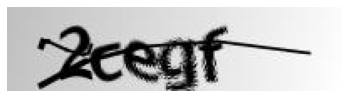

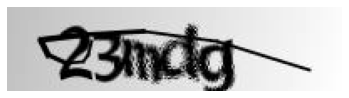

In [5]:
# calling function to show the images
show_img(img1)
show_img(img2)

### Image Preprocesing

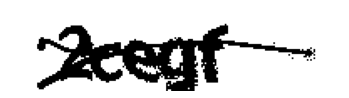

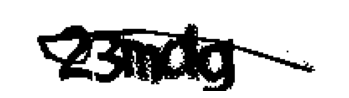

In [6]:
# adaptive thresholding- to change lighting conditions and obtain an abstract image 
thresh_img1 = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
thresh_img2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

show_img(thresh_img1)
show_img(thresh_img2)

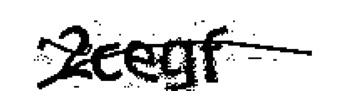

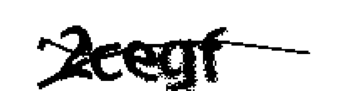

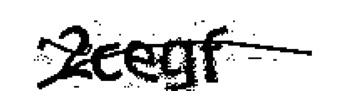

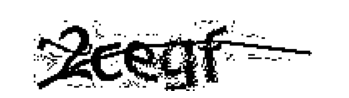

In [7]:
#USING ADAPTIVE_THRESH_MEAN_C (MY)
thresh_img1 = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
show_img(thresh_img1)
#tried bunch of experimental values shown below.
ret,th1 = cv2.threshold(img1,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img1,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
show_img(th1)
show_img(th2)
show_img(th3)

dilation- to obtain a sharp, clear image. 
The dilation increases the white region in the image or the size of the foreground object increases
Taking a matrix of size 2 as the kernel with which the image is convolved. dtype is uint8 for 8-bit images (0-255)

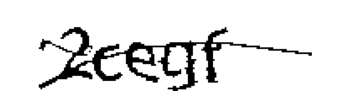

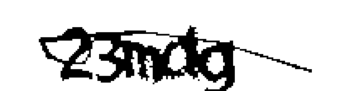

In [8]:
# dilation- to obtain a sharp, clear image. 
dil_img1 = cv2.dilate(thresh_img1, np.ones((2,2), np.uint8), iterations=1)
dil_img2 = cv2.dilate(thresh_img2, np.ones((2,2), np.uint8), iterations=1)

show_img(dil_img1)
show_img(dil_img2)

### Segmenting the Image

In [9]:
cv2.rectangle(dil_img1, (30,12), (50,49), 0, 1)
cv2.rectangle(dil_img1, (50,12), (70,49), 0, 1)
cv2.rectangle(dil_img1, (70,12), (90,49), 0, 1)
cv2.rectangle(dil_img1, (90,12), (110,49),0, 1)
cv2.rectangle(dil_img1, (110,12),(130,49),0, 1)

cv2.rectangle(dil_img2, (30,12), (50,49), 0, 1)
cv2.rectangle(dil_img2, (50,12), (70,49), 0, 1)
cv2.rectangle(dil_img2, (70,12), (90,49), 0, 1)
cv2.rectangle(dil_img2, (90,12), (110,49),0, 1)
cv2.rectangle(dil_img2, (110,12),(130,49),0, 1)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

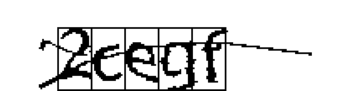

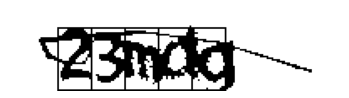

In [10]:
show_img(dil_img1)
show_img(dil_img2)

### Converting Images to Appropriate Samples

Keras uses the img_to_array() function to convert the PIL image into numpy. The API also provides the array_to_img() function, which can be used for converting an array of pixel data into a PIL image.

In [11]:
def at_img(img) :
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

def dil_img(img) :
    return cv2.dilate(img, np.ones((2,2), np.uint8), iterations = 1)

In [12]:
# initializing the path to loop through all images
path = '/Users/tthakur/Downloads/Datasets/'

In [13]:
X = []  # for storing broken up image as a list
y = []  # for keeping track of labels

for image in os.listdir(path):  # for all images in the dataset

    img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)# reading image in grayscale
    
    img = at_img(img)   # applying adaptive thresholding
    img = dil_img(img)  # diluting the image
    
    # segmenting the image
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    
    # analyzing results for 1 image
    for i in range(5) :
        X.append(img_to_array(Image.fromarray(image_list[i])))  # saving the image's segmented list 
        y.append(image[i])                                      # saving the label for each character
        
X = np.array(X)
y = np.array(y)

In [14]:
print(X.shape)
print(y.shape)

(5350, 40, 20, 1)
(5350,)


In [15]:
# scaling X: The general range for pixel is 0 to 255. So just by dividing by 255, will convert it to range from 0 to 1.
X /= 255.0

[]

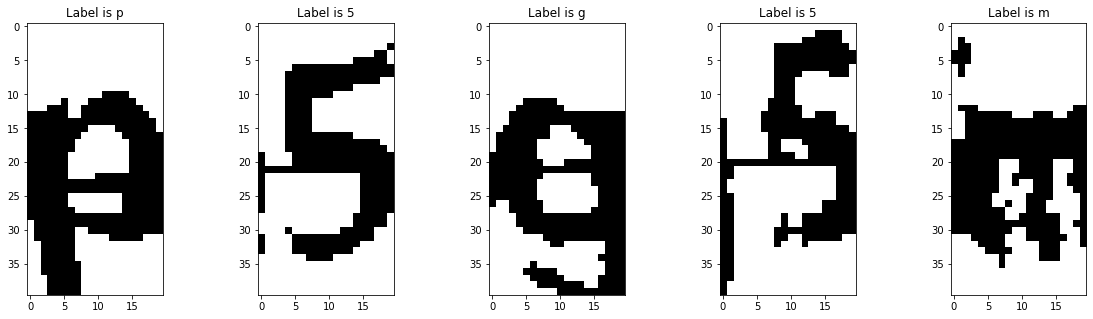

In [16]:
# displaying a segmented image
plt.figure(figsize = (20,5))
for i in range(5) :
    plt.subplot(1,5,i+1)
    plt.imshow(X[i], 'gray')
    plt.title('Label is ' + str(y[i]))
plt.plot()

### Visualizing Data

In [17]:
# checking frequency of occurance of different characters
temp = set(y)
for t in temp:
    print('Frequency of ' + t + ': ' + str(len(y[y == t])))

Frequency of 4: 289
Frequency of 7: 262
Frequency of 3: 271
Frequency of g: 281
Frequency of n: 540
Frequency of b: 247
Frequency of d: 269
Frequency of 8: 272
Frequency of x: 271
Frequency of c: 276
Frequency of w: 244
Frequency of 2: 270
Frequency of f: 277
Frequency of m: 282
Frequency of e: 245
Frequency of 5: 288
Frequency of p: 259
Frequency of 6: 267
Frequency of y: 240


In [18]:
#Dataframe - 2-dimensional labeled data structure with columns of Characters and Count??
temp_df = pandas.DataFrame({'Characters' : [t for t in temp], 'Count' : [len(y[y==t]) for t in temp]})


Text(0.5, 1.0, 'Label distribution in CAPTCHAS')

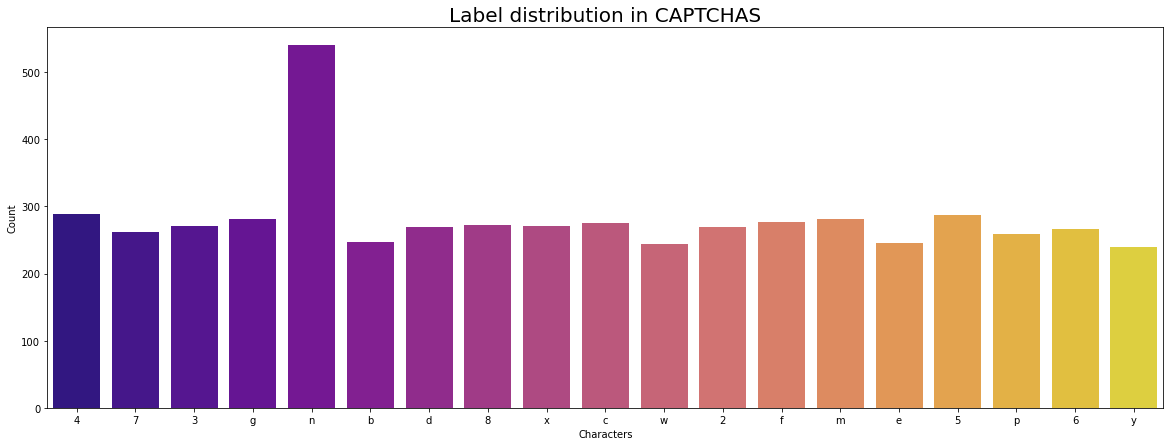

In [19]:
plt.figure(figsize = (20,7))
seaborn.barplot(x = 'Characters', y = 'Count', data = temp_df, palette = 'plasma')
plt.title('Label distribution in CAPTCHAS', fontsize = 20)

### One hot Encoding
Used one hot encoding since this model has categorical variables where no such ordinal relationship exists. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.
Sparse matrix = False

In [20]:
#Why use 2 encoder?
y_combine = LabelEncoder().fit_transform(y)  # encoding first
#y_one_hot = OneHotEncoder(sparse = False).fit_transform(y.reshape(len(y),1))
y_one_hot = OneHotEncoder(sparse = False).fit_transform(y_combine.reshape(len(y_combine),1)) #reshape to give a new shape to array without changing the data

In [21]:
# let's see how encoding looks for one of the characters
#character either alphabet/number, count is freq of each character in dataset and labels are names corresponding to an image section.
print('Character: ' + str(y[1]))
print('Label: ' + str(y_combine[1]))
print('Count: ' + str(len(y_combine[y_combine == y_combine[1]])))

Character: 5
Label: 3
Count: 288


In [22]:
# for mapping back
info = {y_combine[i] : y[i] for i in range(len(y))}
info

{15: 'p',
 3: '5',
 12: 'g',
 13: 'm',
 10: 'e',
 5: '7',
 0: '2',
 8: 'c',
 9: 'd',
 14: 'n',
 4: '6',
 6: '8',
 16: 'w',
 11: 'f',
 7: 'b',
 18: 'y',
 17: 'x',
 2: '4',
 1: '3'}

In [23]:
print(X.shape)
print(y_one_hot.shape)  # one hot encoded form

(5350, 40, 20, 1)
(5350, 19)


### Splitting Dataset for Training & Testing

In [24]:
# splitting in the ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, random_state = 0)

### CNN Creation 
A convolution multiplies a matrix of pixels with a filter matrix or ‘kernel’ and sums up the multiplication values. Then the convolution slides over to the next pixel and repeats the same process until all the image pixels have been covered.

I used sequential model.  add() function is used to add layers to the model. First layers is Conv2D layer. These are convolution layers that will deal with our input images, which are seen as 2-dimensional matrices. 128, 32 16 are the number of nodes in each layer. These are all calculated experimentally. Kernel size gives us the filter matrix of 3x3. Activation is the activation function for the layer. The activation function we will be using for our first 2 layers is the ReLU, or Rectified Linear Activation. This activation function has been proven to work well in neural networks.
Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.One of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.

In [25]:
model = Sequential()

model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu')) #good to start with the smallest filter size first
model.add(BatchNormalization()) #to standardize the output of hidden layers
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
#model.add(Dropout(0.2))


model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
#model.add(Dropout(0.2))

model.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
#model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(19, activation = 'softmax'))
    
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

2022-07-30 20:45:29.271909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Image Data Generation

In [46]:
#shift the image along X-axis by 20% and Y-axis by 20%. rotation_range for rotating the image at an angle from 0 to 180 degrees.
traingen = ImageDataGenerator(rotation_range = 5, width_shift_range = [-2,2])
traingen.fit(X_train)

In [47]:
train_set = traingen.flow(X_train, y_train)

In [48]:
trainX, trainy = train_set.next()

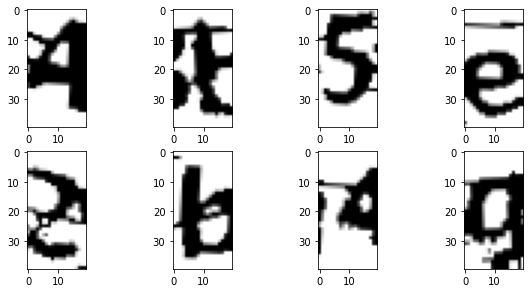

In [49]:
# augmented images with rotations and shifts
plt.figure(figsize = (10,10))
hi = 32
lo = 0
for i in range(8) :
    plt.subplot(4,4,i+1)
    x = np.random.randint(lo, hi)
    plt.imshow(trainX[x], 'gray')
plt.show()

### Setting up Model Checkpoint

A good use of checkpointing is to output the model weights each time an improvement is observed during training. Setting save_best_only=True ensures that the latest best model (according to the metric monitored) will not be overwritten. Finally, the verbose=1 setting simply logs a notification to our terminal when a model is being serialized to disk during training. If we instead wanted to monitor the training loss and accuracy the variable would become train_loss and train_acc, respectively for "monitor" parameter.

In [30]:
checkp = ModelCheckpoint('./best_model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)

### Fitting the Model
This will make all invocations of tf.function run eagerly instead of running as a traced graph function.

This can be useful for debugging.

In [31]:
tf.config.run_functions_eagerly(True)  #mainly helpful for debugging

In [32]:
#A number of epochs mean how many times you go through your training set. 
#The model is updated each time a batch is processed, which means that it can be updated multiple times during one epoch
history = model.fit(traingen.flow(X_train, y_train, batch_size = 32), validation_data = (X_test, y_test), epochs = 150, 
                    steps_per_epoch = len(X_train)/32, callbacks = [checkp])

Epoch 1/150


/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


134/133 [==============================] - ETA: 0s - loss: 2.8921 - accuracy: 0.1526
Epoch 1: val_loss improved from inf to 3.08043, saving model to ./best_model.h5
133/133 [==============================] - 18s 136ms/step - loss: 2.8921 - accuracy: 0.1526 - val_loss: 3.0804 - val_accuracy: 0.0551
Epoch 2/150
134/133 [==============================] - ETA: 0s - loss: 1.9708 - accuracy: 0.4248
Epoch 2: val_loss did not improve from 3.08043
133/133 [==============================] - 17s 126ms/step - loss: 1.9708 - accuracy: 0.4248 - val_loss: 3.2727 - val_accuracy: 0.0636
Epoch 3/150
134/133 [==============================] - ETA: 0s - loss: 1.5401 - accuracy: 0.5752
Epoch 3: val_loss improved from 3.08043 to 2.84108, saving model to ./best_model.h5
133/133 [==============================] - 17s 125ms/step - loss: 1.5401 - accuracy: 0.5752 - val_loss: 2.8411 - val_accuracy: 0.1000
Epoch 4/150
134/133 [==============================] - ETA: 0s - loss: 1.2741 - accuracy: 0.6544
Epoch 4: va

133/133 [==============================] - 17s 126ms/step - loss: 0.4806 - accuracy: 0.8633 - val_loss: 0.3771 - val_accuracy: 0.9019
Epoch 29/150
134/133 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.8668
Epoch 29: val_loss did not improve from 0.37709
133/133 [==============================] - 17s 124ms/step - loss: 0.4843 - accuracy: 0.8668 - val_loss: 0.4045 - val_accuracy: 0.8869
Epoch 30/150
134/133 [==============================] - ETA: 0s - loss: 0.4635 - accuracy: 0.8701
Epoch 30: val_loss did not improve from 0.37709
133/133 [==============================] - 17s 125ms/step - loss: 0.4635 - accuracy: 0.8701 - val_loss: 0.3869 - val_accuracy: 0.8907
Epoch 31/150
134/133 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.8783
Epoch 31: val_loss improved from 0.37709 to 0.37366, saving model to ./best_model.h5
133/133 [==============================] - 17s 126ms/step - loss: 0.4450 - accuracy: 0.8783 - val_loss: 0.3737 - val_accura

Epoch 57/150
134/133 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.8944
Epoch 57: val_loss did not improve from 0.34097
133/133 [==============================] - 17s 126ms/step - loss: 0.3768 - accuracy: 0.8944 - val_loss: 0.3424 - val_accuracy: 0.9121
Epoch 58/150
134/133 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.8930
Epoch 58: val_loss did not improve from 0.34097
133/133 [==============================] - 17s 125ms/step - loss: 0.3743 - accuracy: 0.8930 - val_loss: 0.3604 - val_accuracy: 0.9131
Epoch 59/150
134/133 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.8860
Epoch 59: val_loss did not improve from 0.34097
133/133 [==============================] - 17s 125ms/step - loss: 0.3802 - accuracy: 0.8860 - val_loss: 0.3645 - val_accuracy: 0.9065
Epoch 60/150
134/133 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8958
Epoch 60: val_loss improved from 0.34097 to 0.33576, saving mo

Epoch 86/150
134/133 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.8998
Epoch 86: val_loss did not improve from 0.32736
133/133 [==============================] - 17s 126ms/step - loss: 0.3255 - accuracy: 0.8998 - val_loss: 0.3386 - val_accuracy: 0.9168
Epoch 87/150
134/133 [==============================] - ETA: 0s - loss: 0.3220 - accuracy: 0.9005
Epoch 87: val_loss did not improve from 0.32736
133/133 [==============================] - 17s 125ms/step - loss: 0.3220 - accuracy: 0.9005 - val_loss: 0.3307 - val_accuracy: 0.9112
Epoch 88/150
134/133 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.9014
Epoch 88: val_loss did not improve from 0.32736
133/133 [==============================] - 17s 126ms/step - loss: 0.3321 - accuracy: 0.9014 - val_loss: 0.3331 - val_accuracy: 0.9075
Epoch 89/150
134/133 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.9030
Epoch 89: val_loss did not improve from 0.32736
133/133 [=====

134/133 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.9100
Epoch 115: val_loss did not improve from 0.32606
133/133 [==============================] - 17s 126ms/step - loss: 0.2937 - accuracy: 0.9100 - val_loss: 0.3661 - val_accuracy: 0.9084
Epoch 116/150
134/133 [==============================] - ETA: 0s - loss: 0.2964 - accuracy: 0.9075
Epoch 116: val_loss did not improve from 0.32606
133/133 [==============================] - 17s 127ms/step - loss: 0.2964 - accuracy: 0.9075 - val_loss: 0.3537 - val_accuracy: 0.9065
Epoch 117/150
134/133 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.9082
Epoch 117: val_loss did not improve from 0.32606
133/133 [==============================] - 17s 126ms/step - loss: 0.2962 - accuracy: 0.9082 - val_loss: 0.3706 - val_accuracy: 0.9084
Epoch 118/150
134/133 [==============================] - ETA: 0s - loss: 0.3079 - accuracy: 0.9026
Epoch 118: val_loss did not improve from 0.32606
133/133 [===========

Epoch 144/150
134/133 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.9114
Epoch 144: val_loss did not improve from 0.32473
133/133 [==============================] - 17s 126ms/step - loss: 0.2704 - accuracy: 0.9114 - val_loss: 0.3426 - val_accuracy: 0.9178
Epoch 145/150
134/133 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.9126
Epoch 145: val_loss did not improve from 0.32473
133/133 [==============================] - 17s 125ms/step - loss: 0.2724 - accuracy: 0.9126 - val_loss: 0.3614 - val_accuracy: 0.9093
Epoch 146/150
134/133 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.9138
Epoch 146: val_loss did not improve from 0.32473
133/133 [==============================] - 17s 127ms/step - loss: 0.2750 - accuracy: 0.9138 - val_loss: 0.3480 - val_accuracy: 0.9206
Epoch 147/150
134/133 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.9065
Epoch 147: val_loss did not improve from 0.32473
133/13

In [33]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f99a06ccbe0>>

### Checking the Accuracy of the Model
Plotting training loss/accuracy vs validation loss/accuracy over the number of epochs. The larger the generalization gap between training and validation curve, the higher the overfitting.

A plot of learning curves shows a good fit if:
The plot of training loss decreases to a point of stability.
The plot of validation loss decreases to a point of stability and has a small gap with the training loss.

Text(0.5, 1.0, 'Model accuracy wrt Epoch')

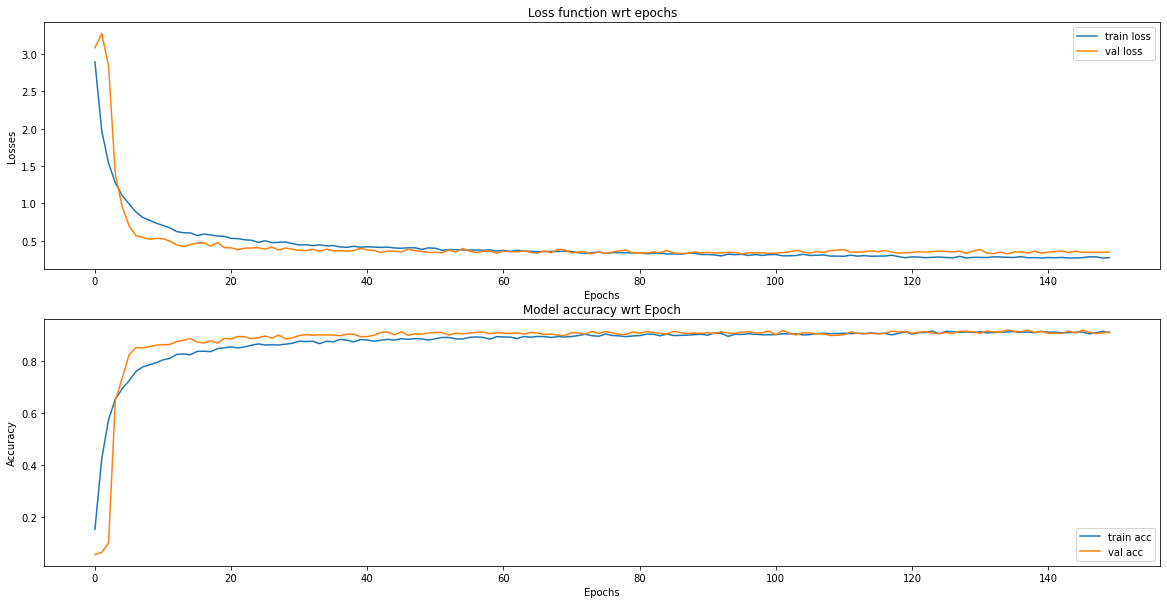

In [34]:
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['train loss','val loss'])
plt.title('Loss function wrt epochs')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train acc' , 'val acc'])
plt.title('Model accuracy wrt Epoch')

### Making Predictions

In [35]:
# loading the model
model = load_model('./best_model.h5')

In [36]:
# making predictions on test set
y_pred = model.predict(X_test)

34/34 [==============================] - 1s 28ms/step


In [37]:
# performing numpy argmax to obtain the value which has the highest probability of being the truth value
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [38]:
target_name = ['2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'm',
 'n',
 'p',
 'w',
 'x',
 'y']

In [39]:
# printing the accuracy & classification report
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names = target_name))

Accuracy: 0.9214953271028037
              precision    recall  f1-score   support

           2       0.94      0.92      0.93        53
           3       0.95      0.96      0.95        55
           4       0.95      0.97      0.96        62
           5       0.95      0.93      0.94        45
           6       0.97      1.00      0.98        60
           7       0.96      0.96      0.96        52
           8       1.00      0.94      0.97        49
           b       0.96      0.98      0.97        54
           c       0.84      0.90      0.87        51
           d       0.91      0.87      0.89        60
           e       0.93      0.88      0.91        49
           f       0.98      0.95      0.97        61
           g       0.98      0.96      0.97        56
           m       0.88      0.51      0.65        59
           n       0.76      0.97      0.85       115
           p       0.92      0.96      0.94        50
           w       0.93      0.90      0.92        4

### Testing on Samples

In [40]:
def test_img(img_path):
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    
    img = at_img(img)
    img = dil_img(img)
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    
    Xdemo = []
    for i in range(5) :
        Xdemo.append(img_to_array(Image.fromarray(image_list[i])))
    
    Xdemo = np.array(Xdemo)
    Xdemo/= 255.0
    
    ydemo = model.predict(Xdemo)
    ydemo = np.argmax(ydemo, axis = 1)

    output ='\0'
    for res in ydemo:
        output+= str(info[res])
    print(output)

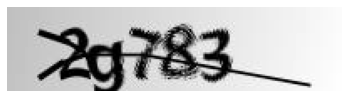

1/1 [==============================] - 0s 22ms/step
 2g783


/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


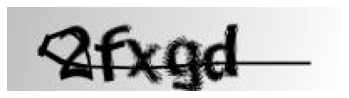

1/1 [==============================] - 0s 23ms/step
 2fxgd


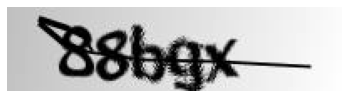

1/1 [==============================] - 0s 21ms/step
 88bgx


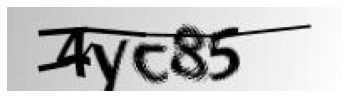

1/1 [==============================] - 0s 26ms/step
 4yc85


In [41]:
test_img('/Users/tthakur/Downloads/Datasets/2g783.png')
test_img('/Users/tthakur/Downloads/Datasets/2fxgd.png')
test_img('/Users/tthakur/Downloads/Datasets/88bgx.png')
test_img('/Users/tthakur/Downloads/Datasets/4yc85.png')